## 1. Importing Libraries

In [ ]:
import os
#Export as html
os.system('jupyter nbconvert --to html CA1_Part_B_CNN_68_75_final.ipynb')

0

In [1]:
#allow duplicate libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
#Checking GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#Check CPU and GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1591674131423326301
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8475029589976588614
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from torchvision import datasets
from torchvision import transforms
from torch import Tensor
from typing import Optional, List, Dict, Tuple
from torchvision.transforms import InterpolationMode
import torch.optim as optim
import time
from torchsummary import summary

In [5]:
#Environment setup
from torch import cuda, optim
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

device = torch.device("cuda:0" if train_on_gpu else "cpu")

multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


## 2. Visualizing Data

In [6]:
# Set random seed constant
torch.manual_seed(1)
np.random.seed(1)

In [7]:
cuda = False
batch_size = 32 #Since these are RGB images, prevent overloading with smaller batch size than part A

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [8]:
#Calculate mean and std here with train_data again
train_data = torchvision.datasets.CIFAR100('./data', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [9]:
print(mean)
print(std)

[0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
[0.26733428587941854, 0.25643846292120615, 0.2761504713263903]


In [10]:
# Normalize training set together with augmentation
transform_train = transforms.Compose([transforms.Resize((80,80)), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(mean,std,inplace=True)])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([transforms.Resize((80,80)),transforms.ToTensor(), transforms.Normalize(mean,std)])

In [11]:
# This is a modified version of original  https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
# Coarse labels is added for cifar100 as an option https://github.com/xiaodongww/pytorch/blob/master/cifarDataset.py

from __future__ import print_function
from PIL import Image
import os
import os.path
import errno
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity


class CIFAR10(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]


    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False, coarse=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.coarse = coarse

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # now load the picked numpy arrays
        if self.train:
            self.train_data = []
            self.train_labels = []
            self.train_coarse_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                    if self.coarse:
                        self.train_coarse_labels += entry['coarse_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
        else:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']
            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
                if self.coarse:
                    self.test_coarse_labels = entry['coarse_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
            if self.coarse:
                coarse_target = self.train_coarse_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]
            if self.coarse:
                coarse_target = self.test_coarse_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        if not self.coarse:
            return img, target
        else:
            return img, target, coarse_target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        root = self.root
        download_url(self.url, root, self.filename, self.tgz_md5)

        # extract file
        cwd = os.getcwd()
        tar = tarfile.open(os.path.join(root, self.filename), "r:gz")
        os.chdir(root)
        tar.extractall()
        tar.close()
        os.chdir(cwd)


class CIFAR100(CIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]

In [12]:
#Download train data
train_data = CIFAR100('./data', train=True,
                 transform=transform_train,
                 download=True, coarse=True)

Files already downloaded and verified


In [13]:
#Download test data
test_data = CIFAR100('./data', train=False,
                 transform=transform_test,
                 download=True, coarse=True)

Files already downloaded and verified


In [14]:
train_data[0]

(tensor([[[ 1.8439,  1.8439,  1.8439,  ...,  0.9930,  0.8170,  0.7730],
          [ 1.8439,  1.8439,  1.8439,  ...,  0.9344,  0.7583,  0.7143],
          [ 1.8439,  1.8439,  1.8439,  ...,  0.6850,  0.5383,  0.5090],
          ...,
          [-0.3565, -0.3565, -0.3565,  ..., -0.1218,  0.0982,  0.1569],
          [-0.5766, -0.5766, -0.5619,  ..., -0.1071,  0.0836,  0.1276],
          [-0.6206, -0.6206, -0.6059,  ..., -0.1071,  0.0836,  0.1276]],
 
         [[ 2.0022,  2.0022,  2.0022,  ...,  1.2988,  1.1153,  1.0694],
          [ 2.0022,  2.0022,  2.0022,  ...,  1.2223,  1.0541,  1.0082],
          [ 2.0022,  2.0022,  2.0022,  ...,  0.9318,  0.7941,  0.7636],
          ...,
          [ 0.2436,  0.2436,  0.2283,  ...,  0.3201,  0.5953,  0.6565],
          [ 0.0142,  0.0142,  0.0142,  ...,  0.4118,  0.6718,  0.7330],
          [-0.0317, -0.0317, -0.0317,  ...,  0.4424,  0.6871,  0.7483]],
 
         [[ 2.0246,  2.0246,  2.0246,  ...,  1.0447,  0.8317,  0.7749],
          [ 2.0246,  2.0246,

In [15]:
print(batch_size)

32


In [16]:
#Create train, val and test laoders using train_length indexes
train_length = train_data.__len__() 
train_indices = np.arange(train_length)
np.random.shuffle(train_indices) 



train_loader = DataLoader(
                        train_data, 
                        batch_size=batch_size, 
                        sampler = SubsetRandomSampler(train_indices[:int(train_length*0.8)]) # 80% of data in train set
                    )

val_loader = DataLoader(
                        train_data, 
                        batch_size=batch_size, 
                        sampler = SubsetRandomSampler(train_indices[int(train_length*0.8):]) #20% of data in validation set
                    )

test_loader = DataLoader(
                        test_data, 
                        batch_size=batch_size,
                    )


# Disable Data Augmentation on Validation Set
val_loader.dataset.transform = transform_test

In [17]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

1250
313
313


## Basic EDA

In [18]:
#Getting size of tensors
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
img, course_labels, fine_labels = batch
print(type(img), type(course_labels), type(fine_labels))
print(img.shape, course_labels.shape, fine_labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 80, 80]) torch.Size([10]) torch.Size([10])


In [19]:
print(course_labels)#Course Labels for 100 classes

tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31])


In [20]:
print(fine_labels)#Fine labels for 20 Super classes

tensor([11, 15,  4, 14,  1,  5, 18,  3, 10, 11])


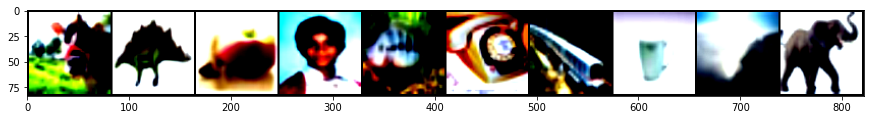

In [21]:
grid = torchvision.utils.make_grid(img, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

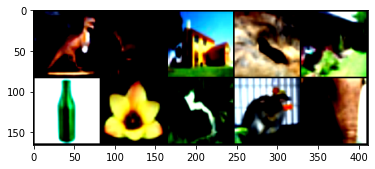

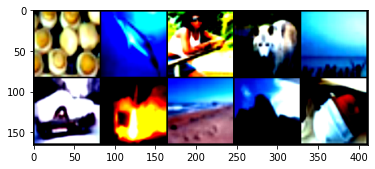

In [22]:
#Basic EDA Visualizations for train and val loader
training_batch = next(iter(train_loader))
validation_batch = next(iter(val_loader))

train_img = torchvision.utils.make_grid(training_batch[0][:10], nrow=5)
plt.imshow(train_img.permute(1,2,0))
plt.show()

validation_img = torchvision.utils.make_grid(validation_batch[0][:10], nrow=5)
plt.imshow(validation_img.permute(1,2,0))
plt.show()

images.shape: torch.Size([32, 3, 80, 80])


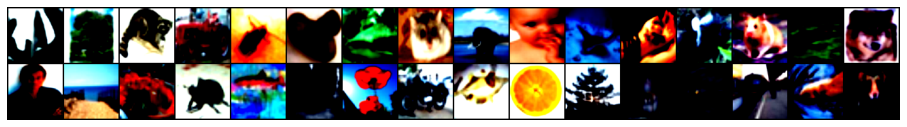

In [23]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, labels, super_class in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

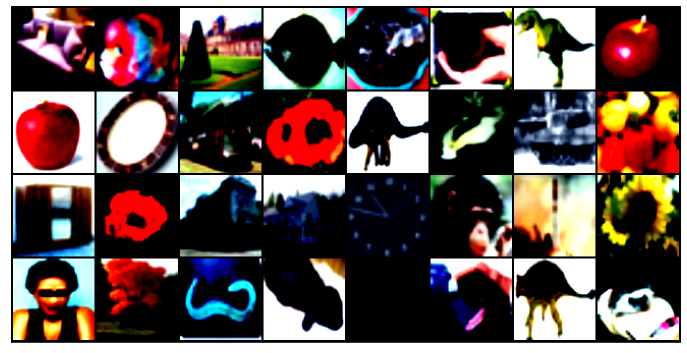

In [26]:
def displayBatch(dl):
    for images, labels, super_class in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
displayBatch(train_loader)
#If you look carefully you will be able to see some images has some small cropped portions in between them. Also some images are horizontally flipped, but that's not easy to tell.

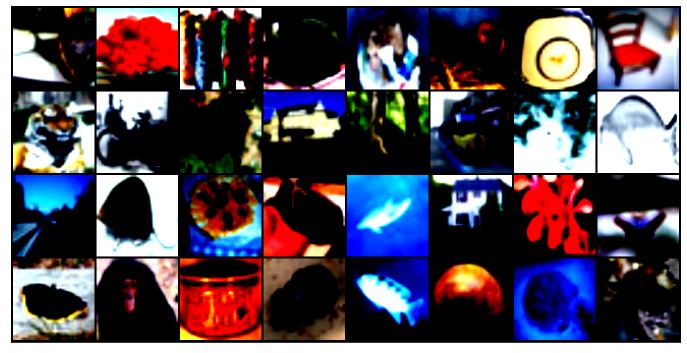

In [27]:
displayBatch(val_loader)#Here's a batch from the **validation dataset**. Unlike the Training set, validation set does not havy any randomness in the images. 

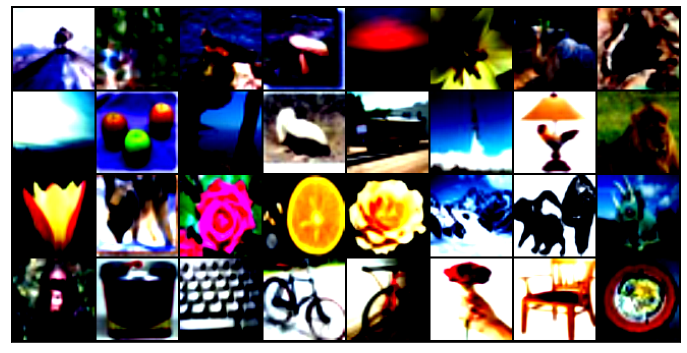

In [28]:
displayBatch(test_loader)

In [36]:
##SUper class labels of 20

def super_label(label):
    super_classes = {
                 0: "aquatic mammals",
                 1: "fish",
                 2: "flowers",
                 3: "food containers",
                 4: "fruit and vegetables",
                 5: "household electrical devices",
                 6: "household furniture",
                 7: "insects",
                 8: "large carnivores",
                 9: "large man-made outdoor things",
                 10:"large natural outdoor scenes",
                 11:"large omnivores and herbivores",
                 12:"medium-sized mammals",
                 13:"non-insect invertebrates",
                 14:"people",
                 15:"reptiles",
                 16:"small mammals",
                 17:"trees",
                 18:"vehicles 1",
                 19:"vehicles 2"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return super_classes[input]

Superclass labels:  large omnivores and herbivores, reptiles, fruit and vegetables, people, fish, household electrical devices, vehicles 1, food containers, large natural outdoor scenes, large omnivores and herbivores, 

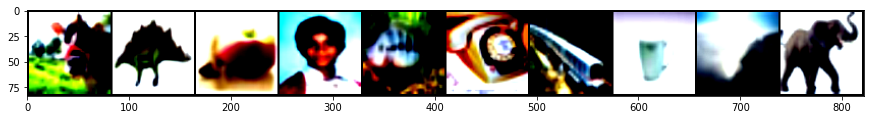

In [38]:
grid = torchvision.utils.make_grid(img, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Superclass labels: ", end=" ")
for i, label in enumerate(fine_labels):
    print(super_label(label), end=", ")

## 3. Modeling

### implement models - vgg-16/19, resnet, efficient net, inception v3 

In [ ]:
#https://rwightman.github.io/pytorch-image-models/models/

In [ ]:
#Model E of technical Paper for VGG, VGG with 19 layers
#https://arxiv.org/pdf/1409.1556.pdf
#https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

<img src="https://iq.opengenus.org/content/images/2020/02/Screenshot-from-2020-02-22-16-32-43.png" alt="alt" width="50%"/>
<img src="https://miro.medium.com/max/980/1*vczqmHklozzgLpZxKAZEjw.jpeg" alt="alt" width="50%"/>


### VGG-16

In [ ]:
epoch = 15
learning_rate = 1e-5
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
#Initializing VGG-16 model
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        #making it 64 channels, not changing input layer size of 32*32, channels look for patterns
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        #[16, 3, 80, 80]
        x = F.relu(self.conv1_1(x))
        #[16, 64, 80, 80]
        x = F.relu(self.conv1_2(x))
        #[16, 64, 80, 80] 32
        x = self.maxpool(x)
        #[16, 64, 40, 40] 16
        x = F.relu(self.conv2_1(x))
        #[16, 128, 40, 40]
        x = F.relu(self.conv2_2(x))
        #[16, 128, 40, 40]
        x = self.maxpool(x)
        #[16, 128, 20, 20] 8
        x = F.relu(self.conv3_1(x))
        #[16, 256, 20, 20]
        x = F.relu(self.conv3_2(x))
        #[16, 256, 20, 20]
        x = F.relu(self.conv3_3(x))
        #[16, 256, 20, 20]
        x = self.maxpool(x)
        #[16, 256, 10, 10] 4
        x = F.relu(self.conv4_1(x))
        #[16, 512, 10, 10]
        x = F.relu(self.conv4_2(x))
        #[16, 512, 10, 10]
        x = F.relu(self.conv4_3(x))
        #[16, 512, 10, 10]
        x = self.maxpool(x)
        #[16, 512, 5, 5]2
        x = F.relu(self.conv5_1(x))
        #[16, 512, 5, 5]
        x = F.relu(self.conv5_2(x))
        #[16, 512, 5, 5]
        x = F.relu(self.conv5_3(x))
        #[16, 512, 5, 5]
        x = self.maxpool(x)
        #[16, 512, 2, 2]1
        #flatten at the end, to extract features
        x = x.reshape(x.shape[0], -1)
        #[16, 2048]
        x = F.relu(self.fc1(x))
        #increase accuracy, reduce overfitting, only changing 50% of neurons
        #[16, 4096]
        x = F.dropout(x, 0.5)
        #[16, 4096]
        x = F.relu(self.fc2(x))
        #[16, 4096]
        x = F.dropout(x, 0.5)
        #[16, 4096]
        x = self.fc3(x)
        #[16, 10]
        return F.log_softmax(x)

In [ ]:
#Calling VGG-16 model for 10 epochs
model = VGG16().to(DEVICE)#set model weight to GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    num_correct=0
    num_samples=0
    startTime = time.time()
    train_loss=0.0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            #valid_loss=loss.item() * data.size(0)
            valid_loss += loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 1.44% Training Loss : 4.536439
Validation Epoch 1 ] Accuracy : 2.76%  Loss : 4.3023947235107425
Epoch 1 ] Time taken in seconds : 166.09091114997864
Training Epoch 2 ] Accuracy : 4.10% Training Loss : 4.205215
Validation Epoch 2 ] Accuracy : 5.49%  Loss : 4.094561883926391
Epoch 2 ] Time taken in seconds : 164.96429753303528
Training Epoch 3 ] Accuracy : 6.82% Training Loss : 4.033995
Validation Epoch 3 ] Accuracy : 7.75%  Loss : 3.950723384094238
Epoch 3 ] Time taken in seconds : 164.63000655174255
Training Epoch 4 ] Accuracy : 9.44% Training Loss : 3.888231
Validation Epoch 4 ] Accuracy : 10.62%  Loss : 3.8142012073516844
Epoch 4 ] Time taken in seconds : 164.72737574577332
Training Epoch 5 ] Accuracy : 12.26% Training Loss : 3.725622
Validation Epoch 5 ] Accuracy : 12.93%  Loss : 3.6834880409240722
Epoch 5 ] Time taken in seconds : 164.87353539466858
Training Epoch 6 ] Accuracy : 14.95% Training Loss : 3.568727
Validation Epoch 6 ] Accuracy : 14.95%  Lo

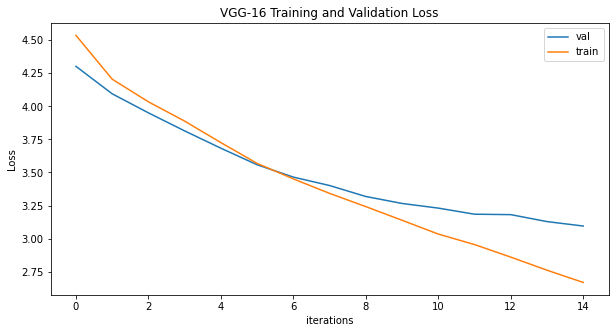

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-16 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

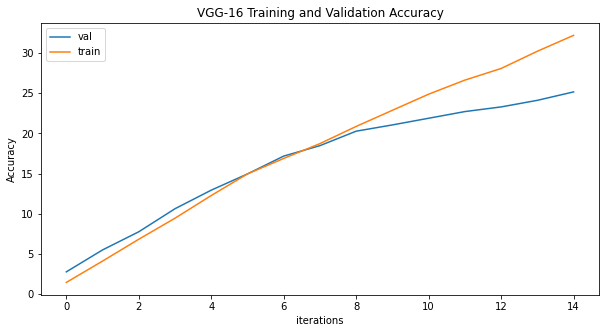

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-16 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 26.28%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
            Conv2d-2           [-1, 64, 80, 80]          36,928
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 40, 40]          73,856
            Conv2d-5          [-1, 128, 40, 40]         147,584
         MaxPool2d-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
            Conv2d-8          [-1, 256, 20, 20]         590,080
            Conv2d-9          [-1, 256, 20, 20]         590,080
        MaxPool2d-10          [-1, 256, 10, 10]               0
           Conv2d-11          [-1, 512, 10, 10]       1,180,160
           Conv2d-12          [-1, 512, 10, 10]       2,359,808
           Conv2d-13          [-1, 512, 10, 10]       2,359,808
        MaxPool2d-14            [-1, 51

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### VGG-19

In [ ]:
#vgg-19
#Initializing VGG-16 model
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        #3_4 for VGG19
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #4_4 for VGG19
        self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        #5_4 for VGG19
        self.conv5_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.relu(self.conv3_4(x))#vgg-19
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.relu(self.conv4_4(x))#vgg-19
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.relu(self.conv5_4(x))#vgg-19
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return F.log_softmax(x)

In [ ]:
#Calling VGG-19 model 
model = VGG19().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct = 0
    num_samples = 0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss += loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 0.92% Training Loss : 4.600063
Validation Epoch 1 ] Accuracy : 1.90%  Loss : 4.532901072692871
Epoch 1 ] Time taken in seconds : 191.52058219909668
Training Epoch 2 ] Accuracy : 3.12% Training Loss : 4.302809
Validation Epoch 2 ] Accuracy : 3.97%  Loss : 4.206952490234375
Epoch 2 ] Time taken in seconds : 192.19359850883484
Training Epoch 3 ] Accuracy : 4.98% Training Loss : 4.134951
Validation Epoch 3 ] Accuracy : 6.05%  Loss : 4.048729561233521
Epoch 3 ] Time taken in seconds : 192.54852986335754
Training Epoch 4 ] Accuracy : 6.74% Training Loss : 4.014568
Validation Epoch 4 ] Accuracy : 7.97%  Loss : 3.942025184249878
Epoch 4 ] Time taken in seconds : 192.5887930393219
Training Epoch 5 ] Accuracy : 8.93% Training Loss : 3.885568
Validation Epoch 5 ] Accuracy : 9.85%  Loss : 3.828638438796997
Epoch 5 ] Time taken in seconds : 192.68829321861267
Training Epoch 6 ] Accuracy : 11.03% Training Loss : 3.764882
Validation Epoch 6 ] Accuracy : 11.71%  Loss : 3.

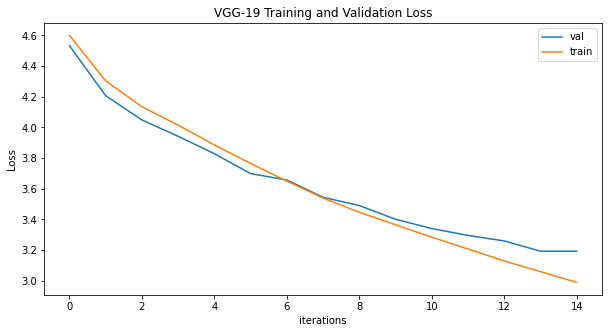

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-19 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

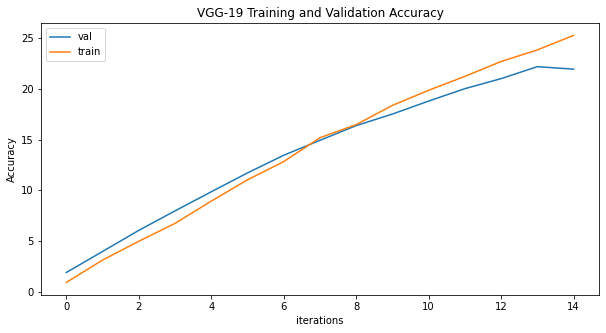

In [ ]:
plt.figure(figsize=(10,5))
plt.title("VGG-19 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 22.72%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
            Conv2d-2           [-1, 64, 80, 80]          36,928
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 40, 40]          73,856
            Conv2d-5          [-1, 128, 40, 40]         147,584
         MaxPool2d-6          [-1, 128, 20, 20]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
            Conv2d-8          [-1, 256, 20, 20]         590,080
            Conv2d-9          [-1, 256, 20, 20]         590,080
           Conv2d-10          [-1, 256, 20, 20]         590,080
        MaxPool2d-11          [-1, 256, 10, 10]               0
           Conv2d-12          [-1, 512, 10, 10]       1,180,160
           Conv2d-13          [-1, 512, 10, 10]       2,359,808
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## AlexNet
AlexNet was a deep neural network that was developed by Alex Krizhevsky and others in 2012. It was designed to classify images for the ImageNet [3] ILSVRC-2012 competition, where it achieved the state of the art results. It was introduced in the paper ImageNet Classification with Deep Convolutional Neural Networks

Alexnet starts with an input layer of 227 x 227 x 3 images , the next convolution layer consists of 96 (11 x 11) filters with a stride of 4. which reduces its dimension by 55 x 55. Followed by a MaxPool layer with 3 x 3 filter along with stride 2. This process goes on and finally reaches the Fully Connected layer with 9216 parameters and the next two Fully Connected layers with 4096 nodes each. In the end, it uses the Softmax function with 1000 output classes.. Alexnet is the first architecture to use ReLU non-linearity , Dropout for regularization and Multi-GPU training[3]
<img src="https://miro.medium.com/max/720/1*RT8gNyu608VSphZwLCoxIA.png" alt="alt" width="50%"/>




## AlexNet

In [ ]:
epoch = 15
learning_rate = 1e-5
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 100),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x)

In [ ]:
#Calling AlexNet model for 10 epochs
model = AlexNet().to(DEVICE)#set model weight to GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct = 0
    num_samples = 0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 3.82% Training Loss : 4.300052
Validation Epoch 1 ] Accuracy : 5.96%  Loss : 4.073127953338623
Epoch 1 ] Time taken in seconds : 97.68235158920288
Training Epoch 2 ] Accuracy : 7.75% Training Loss : 3.954854
Validation Epoch 2 ] Accuracy : 8.72%  Loss : 3.873413157272339
Epoch 2 ] Time taken in seconds : 97.92896556854248
Training Epoch 3 ] Accuracy : 10.15% Training Loss : 3.791255
Validation Epoch 3 ] Accuracy : 11.29%  Loss : 3.7255714889526366
Epoch 3 ] Time taken in seconds : 98.17230916023254
Training Epoch 4 ] Accuracy : 12.21% Training Loss : 3.656337
Validation Epoch 4 ] Accuracy : 12.09%  Loss : 3.6516716991424563
Epoch 4 ] Time taken in seconds : 97.9959945678711
Training Epoch 5 ] Accuracy : 14.78% Training Loss : 3.516694
Validation Epoch 5 ] Accuracy : 15.39%  Loss : 3.483476496887207
Epoch 5 ] Time taken in seconds : 98.60611510276794
Training Epoch 6 ] Accuracy : 16.89% Training Loss : 3.397878
Validation Epoch 6 ] Accuracy : 18.10%  Loss :

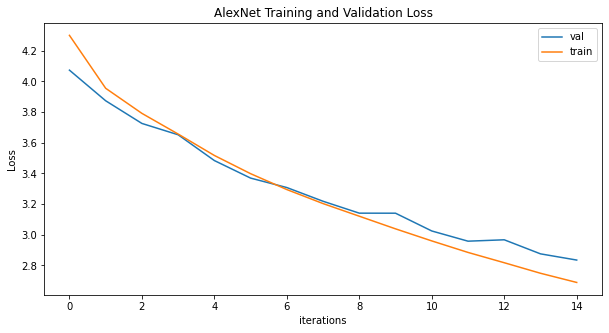

In [ ]:
plt.figure(figsize=(10,5))
plt.title("AlexNet Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

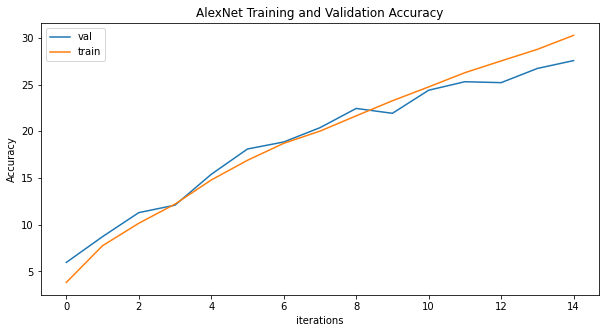

In [ ]:
plt.figure(figsize=(10,5))
plt.title("AlexNet Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 27.75%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 19, 19]          23,296
              ReLU-2           [-1, 64, 19, 19]               0
 LocalResponseNorm-3           [-1, 64, 19, 19]               0
         MaxPool2d-4             [-1, 64, 9, 9]               0
            Conv2d-5            [-1, 192, 9, 9]         307,392
              ReLU-6            [-1, 192, 9, 9]               0
         MaxPool2d-7            [-1, 192, 4, 4]               0
            Conv2d-8            [-1, 384, 4, 4]         663,936
              ReLU-9            [-1, 384, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         884,992
             ReLU-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 256, 4, 4]         590,080
             ReLU-13            [-1, 256, 4, 4]               0
        MaxPool2d-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## ResNet
ResNet was a real deeper architecture which has 152 layers. It was introduced in the paper “Deep Residual Learning for Image Recognition” it won the Imagenet 2015 competition, ever since most of the CNNsare variants of these Resnets. It became so popular since it avoids the vanishing gradient problem, that is when creating deeper nets mostly loss of the network increased after a certain point both in train and test sets, to avoid this major problem, the authors proposed to use a reference to the previous layer [5] to compute the output at a given layer. In ResNet, the output from the previous layer, which is called residual, is added to the output of the current layer.
<img src="https://miro.medium.com/max/1100/1*66l48ybZsnQxWLWc_qOZ1w.jpeg" alt="alt" width="150%"/>
<img src="https://miro.medium.com/max/1100/0*79p7WhWeMd54YRYr.png" alt="alt" width="150%"/>

In [ ]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
learning_rate=1e-5#0.00001 = 1e-5, 0.00005
epoch=15
model = resnet18().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
        
    #Decay learning Rate
    mean_loss=train_loss/len(train_loader)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

Training Epoch 1 ] Accuracy : 7.20% Training Loss : 4.175298
Validation Epoch 1 ] Accuracy : 10.19%  Loss : 3.9382405418396
Epoch 1 ] Time taken in seconds : 253.54014897346497
Training Epoch 2 ] Accuracy : 12.49% Training Loss : 3.792804
Validation Epoch 2 ] Accuracy : 14.01%  Loss : 3.689023621368408
Epoch 2 ] Time taken in seconds : 252.44793701171875
Training Epoch 3 ] Accuracy : 17.10% Training Loss : 3.538097
Validation Epoch 3 ] Accuracy : 17.78%  Loss : 3.4593330448150637
Epoch 3 ] Time taken in seconds : 252.53277897834778
Training Epoch 4 ] Accuracy : 20.74% Training Loss : 3.323033
Validation Epoch 4 ] Accuracy : 21.81%  Loss : 3.260849889755249
Epoch 4 ] Time taken in seconds : 252.46417570114136
Training Epoch 5 ] Accuracy : 24.20% Training Loss : 3.122690
Validation Epoch 5 ] Accuracy : 24.60%  Loss : 3.094657884979248
Epoch 5 ] Time taken in seconds : 252.60486698150635
Training Epoch 6 ] Accuracy : 27.18% Training Loss : 2.952974
Validation Epoch 6 ] Accuracy : 27.53%  

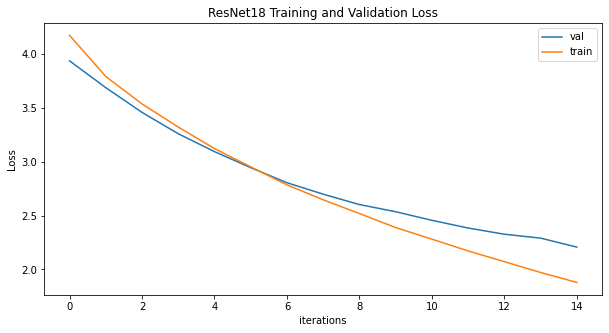

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet18 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

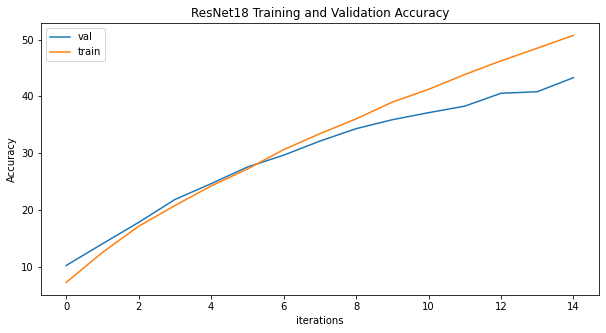

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet18 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

Accuracy 42.96%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,728
       BatchNorm2d-2           [-1, 64, 80, 80]             128
         LeakyReLU-3           [-1, 64, 80, 80]               0
            Conv2d-4           [-1, 64, 80, 80]          36,864
       BatchNorm2d-5           [-1, 64, 80, 80]             128
         LeakyReLU-6           [-1, 64, 80, 80]               0
            Conv2d-7           [-1, 64, 80, 80]          36,864
       BatchNorm2d-8           [-1, 64, 80, 80]             128
        BasicBlock-9           [-1, 64, 80, 80]               0
           Conv2d-10           [-1, 64, 80, 80]          36,864
      BatchNorm2d-11           [-1, 64, 80, 80]             128
        LeakyReLU-12           [-1, 64, 80, 80]               0
           Conv2d-13           [-1, 64, 80, 80]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
learning_rate=1e-5#0.00001 = 1e-5, 0.00005
epoch=15
model = resnet50().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
        
    #Decay learning Rate
    mean_loss=train_loss/len(train_loader)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

Training Epoch 1 ] Accuracy : 4.55% Training Loss : 4.367645
Validation Epoch 1 ] Accuracy : 6.97%  Loss : 4.093472333526611
Epoch 1 ] Time taken in seconds : 612.9840233325958
Training Epoch 2 ] Accuracy : 8.97% Training Loss : 3.967306
Validation Epoch 2 ] Accuracy : 10.10%  Loss : 3.8693906692504885
Epoch 2 ] Time taken in seconds : 604.221825838089
Training Epoch 3 ] Accuracy : 11.68% Training Loss : 3.778541
Validation Epoch 3 ] Accuracy : 12.94%  Loss : 3.6870004177093505
Epoch 3 ] Time taken in seconds : 604.8839964866638
Training Epoch 4 ] Accuracy : 14.81% Training Loss : 3.592165
Validation Epoch 4 ] Accuracy : 16.73%  Loss : 3.5267464962005617
Epoch 4 ] Time taken in seconds : 604.640282869339
Training Epoch 5 ] Accuracy : 17.59% Training Loss : 3.422044
Validation Epoch 5 ] Accuracy : 18.19%  Loss : 3.3824865352630615
Epoch 5 ] Time taken in seconds : 604.3439781665802
Training Epoch 6 ] Accuracy : 20.52% Training Loss : 3.256510
Validation Epoch 6 ] Accuracy : 22.25%  Loss

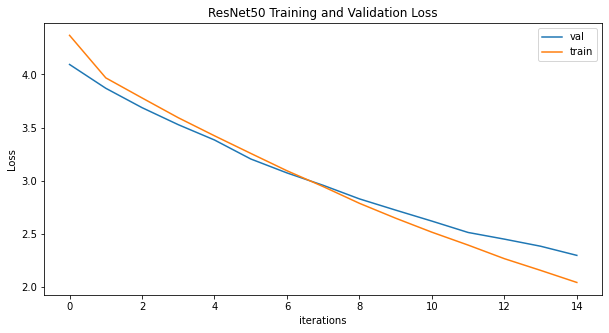

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet50 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

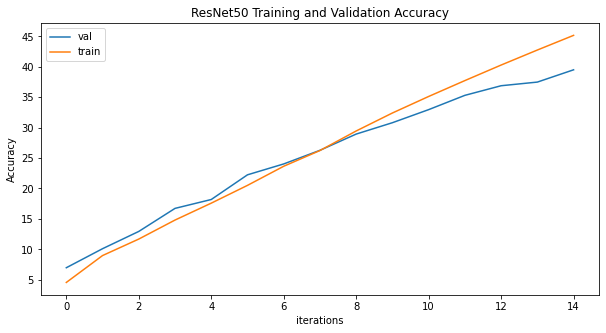

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet50 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

Accuracy 40.07%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,728
       BatchNorm2d-2           [-1, 64, 80, 80]             128
         LeakyReLU-3           [-1, 64, 80, 80]               0
            Conv2d-4           [-1, 64, 80, 80]           4,096
       BatchNorm2d-5           [-1, 64, 80, 80]             128
         LeakyReLU-6           [-1, 64, 80, 80]               0
            Conv2d-7           [-1, 64, 80, 80]          36,864
       BatchNorm2d-8           [-1, 64, 80, 80]             128
         LeakyReLU-9           [-1, 64, 80, 80]               0
           Conv2d-10          [-1, 128, 80, 80]           8,192
      BatchNorm2d-11          [-1, 128, 80, 80]             256
           Conv2d-12          [-1, 128, 80, 80]           8,192
      BatchNorm2d-13          [-1, 128, 80, 80]             256
       BottleNeck-14          [-1, 128,

In [ ]:
learning_rate=1e-5#0.00001 = 1e-5, 0.00005
epoch=15
model = resnet152().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
sum = 0

#epoch=10
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
        
    #Decay learning Rate
    mean_loss=train_loss/len(train_loader)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)

            loss = criterion(scores,targets)
            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
    
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

Training Epoch 1 ] Accuracy : 2.89% Training Loss : 4.495122
Validation Epoch 1 ] Accuracy : 4.51%  Loss : 4.269070251464844
Epoch 1 ] Time taken in seconds : 1350.742957830429
Training Epoch 2 ] Accuracy : 5.95% Training Loss : 4.136976
Validation Epoch 2 ] Accuracy : 7.26%  Loss : 4.025690678787232
Epoch 2 ] Time taken in seconds : 1342.691875219345
Training Epoch 3 ] Accuracy : 8.76% Training Loss : 3.936556
Validation Epoch 3 ] Accuracy : 9.41%  Loss : 3.884525412750244
Epoch 3 ] Time taken in seconds : 1343.667017698288
Training Epoch 4 ] Accuracy : 11.59% Training Loss : 3.766872
Validation Epoch 4 ] Accuracy : 12.76%  Loss : 3.6924790473937987
Epoch 4 ] Time taken in seconds : 1344.0625874996185
Training Epoch 5 ] Accuracy : 14.34% Training Loss : 3.591790
Validation Epoch 5 ] Accuracy : 15.49%  Loss : 3.522620672607422
Epoch 5 ] Time taken in seconds : 1343.8779780864716
Training Epoch 6 ] Accuracy : 17.85% Training Loss : 3.400850
Validation Epoch 6 ] Accuracy : 18.84%  Loss :

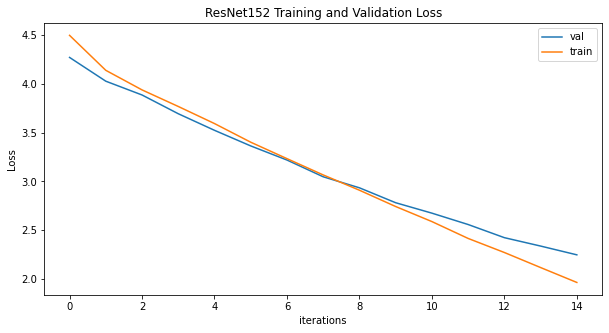

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet152 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

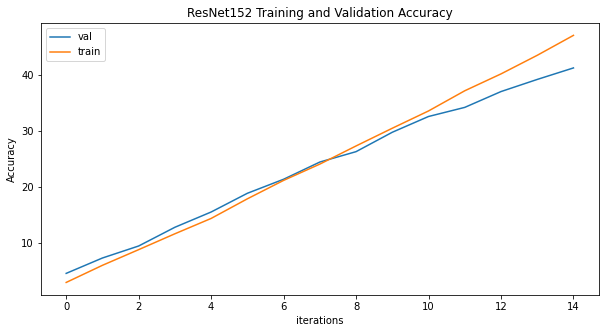

In [ ]:
plt.figure(figsize=(10,5))
plt.title("ResNet152 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

Accuracy 42.01%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,728
       BatchNorm2d-2           [-1, 64, 80, 80]             128
         LeakyReLU-3           [-1, 64, 80, 80]               0
            Conv2d-4           [-1, 64, 80, 80]           4,096
       BatchNorm2d-5           [-1, 64, 80, 80]             128
         LeakyReLU-6           [-1, 64, 80, 80]               0
            Conv2d-7           [-1, 64, 80, 80]          36,864
       BatchNorm2d-8           [-1, 64, 80, 80]             128
         LeakyReLU-9           [-1, 64, 80, 80]               0
           Conv2d-10          [-1, 128, 80, 80]           8,192
      BatchNorm2d-11          [-1, 128, 80, 80]             256
           Conv2d-12          [-1, 128, 80, 80]           8,192
      BatchNorm2d-13          [-1, 128, 80, 80]             256
       BottleNeck-14          [-1, 128,

<h2>Part B CIFAR-100 Model Comparisons at baseline 15 epochs</h2>
<table>
<thead><tr><th>Model</th><th>Training Loss</th><th>Training Accuracy</th><th>Validation Loss</th><th>Validation Accuracy</th><th>Test Accuracy</th><th>Total Training Time</th><th>Total Parameters</th><th>Remarks</th></tr></thead>
<tbody>
<tr><td>VGG-16</td><td>2.67</td><td>32.20%</td><td>3.10</td><td>25.16%</td><td>26.28%</td><td>41 minutes</td><td>40.3Million</td><td>Low accuracy scores and some signs of overfitting</td></tr>
<tr><td>VGG-19</td><td>2.99</td><td>25.26%</td><td>3.19</td><td>21.93%</td><td>22.72%</td><td>48 minutes</td><td>45.6Million</td><td>Lower accuracy scores compared to VGG-16 and some signs of overfitting</td></tr>
<tr><td>AlexNet</td><td>2.69</td><td>30.26%</td><td>2.83</td><td>27.56%</td><td>27.75%</td><td>24 minutes</td><td>57.4Million</td><td>Lower accuracy scores compared to VGG-16 and but no signs of overfitting</td></tr>
<tr><td>ResNet18</td><td>1.88</td><td>50.73%</td><td>2.21</td><td>43.28%</td><td>42.96%</td><td>1hr 3 minutes</td><td>11.2Million</td><td>High accuracy scores and some signs of overfitting</td></tr>
<tr><td>ResNet50</td><td>2.04</td><td>45.18%</td><td>2.30</td><td>39.52%</td><td>40.07%</td><td>2 hr 30 minutes</td><td>16.8Million</td><td>Lower accuracy scores than ResNet18 and but less signs of overfitting</td></tr>
<tr><td>ResNet152</td><td>1.96</td><td>47.10%</td><td>2.25</td><td>41.27%</td><td>42.01%</td><td>5hr 35 minutes</td><td>43.3Million</td><td>Lower accuracy scores than ResNet18 and clear signs of overfitting</td></tr>
</tbody>
</table>

## My Own Model
With Inspiration from the previous models, we can see the analysis below:

VGGNet

VGG-16 and VGG-19, VGG-16 performed better than the VGG-19, VGG-16 achieving a higher final test accuracy of 26.28% compared to VGG-19's 22.72%. However both VGG architectures performed rather poorly as compared to the other architectures such as ResNet and AlexNet. With a standard number of epochs as 15, VGG is considered the worse performing with loss accuracy scores and higher loss values, the plots also showed signs of overfitting

AlexNet

AlexNet achieved a accuracy score of 27.75%, the AlexNet performed better as compared to VGG16 however the accuracy scores were still relatively low as compared to the ResNet. Loss values fo the alexnet was lower than the VGG as well with clear trends in the plots and low signs of overfitting, AlexNet is in the correct direction but will not be used as final model, I will use some elements from AlexNet such as avg pooling in my ResNet as well to see if it helps

ResNet

3.ResNet18, 50 and 152 achieved accuracy scores of 42.96%, 30.07% and 42.01%, making ResNet the best performing architecture for this dataset. As you can see the ResNet18 despite being less complex took less time to train and also achieved the best accuracy scores, thus i intend to make my model even less complex like a ResNet9. The loss curves had low signs of overfitting but there is some signs shown. Regardless, accuracy is prioritized for part B.

My Own model shall consist of elements inspired from the better performing models in these experiments, such as the ResNet. I will be creating my own model architecture inspired by these architectural experiments back in 2013-2015, why not after 2016? the models which are SOTA after 2016 such as EfficientNet and InceptionV3 were my initial choices. However this module's purpose is to design a model architecure from scratch and not import pretrained and prebuilt architectures. Architectures like the Inception v3 are exceptionally large and is extremely inefficient to built from scratch, Thus, i will be crafting my own inspired model architecture which will hopefully achieve a good level of performance.

My first custom model will be a ResNet18 inspired model

The experimental tweaks i did are listed below:

I reduced the number of convolutional 2d layers to reduce complexity
I added Batch Normalization as it has a regularizing effect on CNN by normalizing inputs to layers deeper into a network
I did global average pooling's pytorch version of adaptive avg pool, Global pooling helps prevent overfitting whereas VGG only used max pooling
Dropout, since i wanted to reduce overfitting a dropout was added before the final classification

1. Learning Rate I used a Learning rate schedular which decreases learning rate by 1/10th if epoch's avg accuracy instead of loss function doesn't decrease after 5 epochs. this is because i am prioritizing accuracy over loss values in Part B, for Part A the loss values still mattered so i prevented overfitting using Early Stopping
2. Number of Epochs, I increased the number of epochs to 100, since part B's dataset is more complex
3. I added Avg Pooling layers inspired by AlexNet
4. I reduced the layers of ResNet18 to ResNet9 to reduce complexity
7. Batch Size (small for more regularization, large for less regularization)

I decided to tune the Edited ResNet Architecture inspired by ResNet 18 and ResNet 50 adn AlexNet

In [ ]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
#Max no. of epochs
epoch=50
model = resnet18().to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=1e-5, momentum=0.9)
#Weight decay for L2 regularization

#Instead of reducing learning rate based on epochs, it reduces lr when a metric has stopped improving
#Scheduler reads a metrics quantity and if no improvement is seen for a 'patience' number of epochs, lr is reduced
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
#Min mode to reduce when quantity monitored stopped, reduce by factor of 2-10 has shown improvements, patience if 4th epoch shows no improvement, decrease

In [ ]:
sum = 0

#epoch=50
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Early stop variables
n_epochs_stop = 4
epochs_no_improve = 0
early_stop = False
min_val_loss=100

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            ## Forward Pass
            scores = model(data)
            loss = criterion(scores,targets)

            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
        #Early stopping
        if (valid_loss/len(val_loader)) < min_val_loss:
            epochs_no_improve=0
            min_val_loss=(valid_loss/len(val_loader))
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_loss:{min_val_loss}')
        else:
            epochs_no_improve+=1
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_loss:{min_val_loss}')
    
        if e>5 and epochs_no_improve==n_epochs_stop:
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_loss:{min_val_loss}')
            early_stop=True
    
    #Learning rate scheduler
    scheduler.step(valid_loss/len(val_loader))
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')
    #Check early stopping condition
    if early_stop:
      print("Early Stopping")
      break
    

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

Training Epoch 1 ] Accuracy : 5.78% Training Loss : 4.184345
Validation Epoch 1 ] Accuracy : 9.78%  Loss : 3.884664725494385
Epoch 1 ] Time taken in seconds : 255.95888495445251
Training Epoch 2 ] Accuracy : 12.37% Training Loss : 3.675758
Validation Epoch 2 ] Accuracy : 16.44%  Loss : 3.4838869850158694
Epoch 2 ] Time taken in seconds : 245.7144570350647
Training Epoch 3 ] Accuracy : 20.64% Training Loss : 3.177385
Validation Epoch 3 ] Accuracy : 25.19%  Loss : 3.0076019792556763
Epoch 3 ] Time taken in seconds : 245.2841989994049
Training Epoch 4 ] Accuracy : 28.85% Training Loss : 2.746610
Validation Epoch 4 ] Accuracy : 31.51%  Loss : 2.634224953842163
Epoch 4 ] Time taken in seconds : 245.03147792816162
Training Epoch 5 ] Accuracy : 36.14% Training Loss : 2.384773
Validation Epoch 5 ] Accuracy : 37.50%  Loss : 2.3461171855926515
Epoch 5 ] Time taken in seconds : 243.98288869857788
Training Epoch 6 ] Accuracy : 42.56% Training Loss : 2.111035
Validation Epoch 6 ] Accuracy : 42.25% 

## Hyper-parameter settings 
<table>
<thead><tr><th>Hyper-parameters</th><th>Description</th></tr></thead>
<tbody>
<tr><td>lr=0.01</td><td>Learning Rate with early stopping, between 1e-3 to 1e-4</td></tr>
<tr><td>momentum=0.9</td><td>Momentum Factor</td></tr>
<tr><td>weight_decay=0.001</td><td>Weight decay for L2 Penalty between 1e-3 to 1e-4</td></tr>
<tr><td>epochs=50</td><td>Number of epochs to train</td></tr>
<tr><td>batch_size=16/32</td><td>smaller Batch size to prevent overloading</td></tr>
<tr><td>Learning Rate scheduler: ReduceLROnPlateu</td><td>LR scheduler reduces lr based on validation loss metric</td></tr>
<tr><td>Loss Function: Cross Entropy Loss</td><td>Loss Function</td></tr>
<tr><td>Optimizer: SGD</td><td>Optimizer between Adam and SGD</td></tr>
</tbody>
</table>

<table>
<thead><tr><th>Loss Function</th><th>Optimizer</th><th>Learning Rate Scheduler</th></tr></thead>
<tbody>
<tr><td>Cross-Entropy Loss</td><td>SGD with momentum</td><td>LambdaLR (Sets the learning rate of each parameter group to the initial lr times a given function. When last_epoch=-1, sets initial lr as lr.)</td></tr>
<tr><td>NLLoss</td><td>Adam</td><td>MultiplicativeLR (#works the same but multiplies the lr of each parameter group by the factor given in specified function, so it gets lower)</td></tr>
<tr><td>Between Cross-Entropy and NLLoss, Cross Entropy showed better results with higher accuracy and loss functions</td><td>Between SGD and Adam, although Adam had faster learning rates, SGD had more stable loss curve trends</td><td>StepLR (It decays lr of each parameter grp by gamma every step size epochs)</td></tr>
<tr><td>(Use Cross-Entropy)</td><td>(Use SGD with Momentum)</td><td>MultiStepLR (It decays lr of each parameter grp by gamma every milestone)</td></tr>
<tr><td>(Use Cross-Entropy)</td><td>(Use SGD with Momentum)</td><td>ReduceLROnPlateu (Instead of reducing learning rate based on epochs, it reduces lr when a metric has stopped improving, metric used here will be validation loss)</td></tr>
<tr><td>Remarks: Best Parameters: Cross Entropy Loss, SGD with momentum and weight decay, ReduceLROnPlateu because it reduced LR based on performance and not epochs</td></tr>
</tbody>
</table>

In [ ]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CustomResNet(nn.Module):#ResNet 9 architecture
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(#nn.MaxPool2d(2), # 1028 x 4 x 4
                                        nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(), # 4112  #if not jsut put a avg pooling layer here
                                        nn.Linear(1028, num_classes)) # 4112 -> 100, 1028
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return F.log_softmax(out)

In [ ]:
#Max no. of epochs
epoch=100
model = CustomResNet(3,100).to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=0.001, momentum=0.9)
#Weight decay for L2 regularization

#Instead of reducing learning rate based on epochs, it reduces lr when a metric has stopped improving
#Scheduler reads a metrics quantity and if no improvement is seen for a 'patience' number of epochs, lr is reduced
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
#Min mode to reduce when quantity monitored stopped, reduce by factor of 2-10 has shown improvements, patience if 4th epoch shows no improvement, decrease

Experi

In [ ]:
sum = 0

#epoch=50
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Early stop variables
epochs_no_improve = 0
early_stop = False
min_val_acc=-1#Set

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets, super_class) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        super_class = super_class.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model(data)
        #find the loss
        loss = criterion(scores,targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets, super_class) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            super_class = super_class.to(DEVICE)

            ## Forward Pass
            scores = model(data)
            loss = criterion(scores,targets)

            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
        #Early stopping
        if (float(num_correct) / float(num_samples) * 100) > min_val_acc:
            epochs_no_improve=0
            min_val_acc=(float(num_correct) / float(num_samples) * 100)
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_acc:{min_val_acc}')
        else:
            epochs_no_improve+=1
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_acc:{min_val_acc}')
    
        if e>5 and epochs_no_improve==5:
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_acc:{min_val_acc}')
            early_stop=True
    
    #Learning rate scheduler
    scheduler.step(valid_loss/len(val_loader))
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')
    #Check early stopping condition
    if early_stop:
      print("Early Stopping")
      break
    

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 8.87% Training Loss : 4.015974
Validation Epoch 1 ] Accuracy : 15.76%  Loss : 3.516394911482692
Epoch 1 ] Time taken in seconds : 198.60028839111328
Training Epoch 2 ] Accuracy : 21.16% Training Loss : 3.174652
Validation Epoch 2 ] Accuracy : 26.73%  Loss : 2.846382598145701
Epoch 2 ] Time taken in seconds : 198.00085592269897
Training Epoch 3 ] Accuracy : 34.05% Training Loss : 2.491299
Validation Epoch 3 ] Accuracy : 38.48%  Loss : 2.3071235483065964
Epoch 3 ] Time taken in seconds : 197.96570348739624
Training Epoch 4 ] Accuracy : 44.21% Training Loss : 2.042689
Validation Epoch 4 ] Accuracy : 46.08%  Loss : 1.9855493425180355
Epoch 4 ] Time taken in seconds : 198.08650612831116
Training Epoch 5 ] Accuracy : 51.79% Training Loss : 1.739866
Validation Epoch 5 ] Accuracy : 50.90%  Loss : 1.8019433421448778
Epoch 5 ] Time taken in seconds : 198.07648468017578
Training Epoch 6 ] Accuracy : 57.26% Training Loss : 1.506007
Validation Epoch 6 ] Accuracy : 52.4

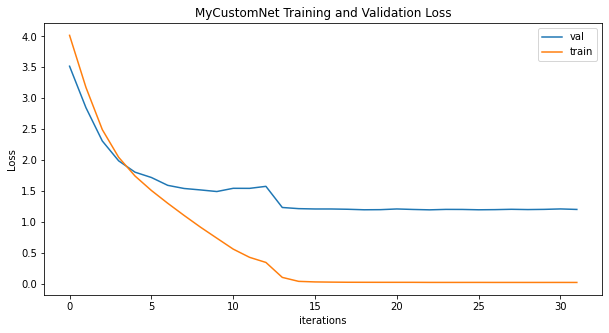

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

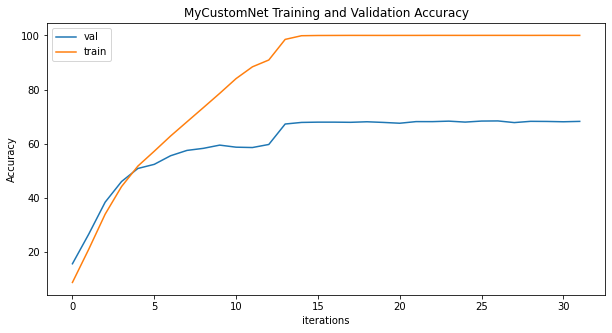

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets, fine_targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    fine_targets = fine_targets.to(DEVICE)
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 68.09%


In [ ]:
summary(model,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
            Conv2d-4          [-1, 128, 80, 80]          73,856
       BatchNorm2d-5          [-1, 128, 80, 80]             256
              ReLU-6          [-1, 128, 80, 80]               0
         MaxPool2d-7          [-1, 128, 40, 40]               0
            Conv2d-8          [-1, 128, 40, 40]         147,584
       BatchNorm2d-9          [-1, 128, 40, 40]             256
             ReLU-10          [-1, 128, 40, 40]               0
           Conv2d-11          [-1, 128, 40, 40]         147,584
      BatchNorm2d-12          [-1, 128, 40, 40]             256
             ReLU-13          [-1, 128, 40, 40]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Testing Model

In [ ]:
fine_labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "cra",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


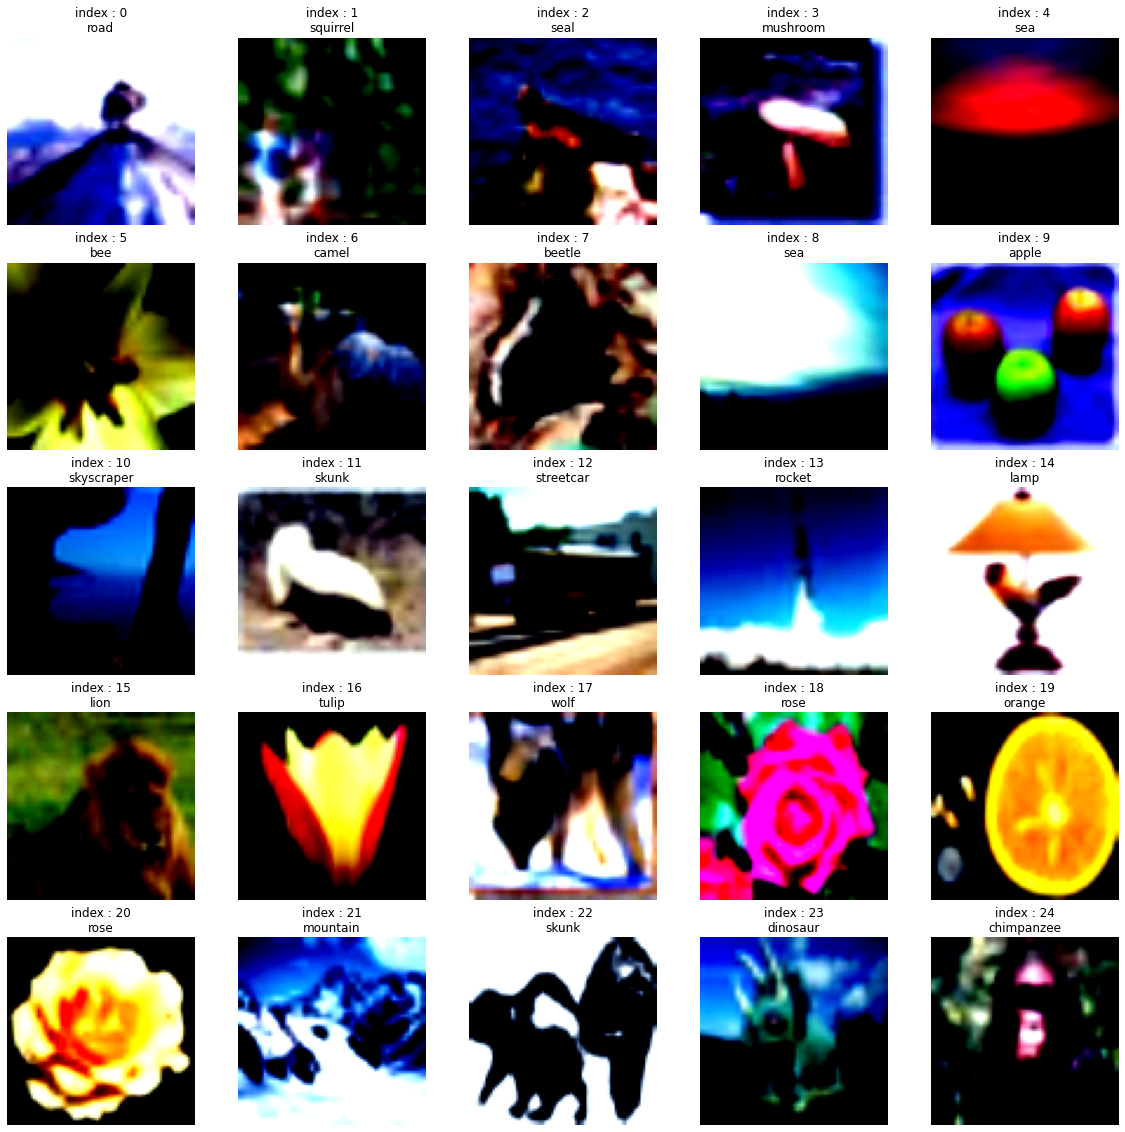

In [ ]:
test_images = iter(test_loader)
plt.figure(figsize=(20, 20)) # Set figure size 
data, target, fine_targets= next(test_images) # get the images from the test images that we iterate over
image = data.to(DEVICE)
labels = target.to(DEVICE)
#img, labels = images.to(device), labels.to(device) # pass images to GPU
model.eval() # Set model to evaluation mode 
predictions = model(image) # Predict the probabilities of each class for the image
y_pred = torch.argmax(predictions, dim=1).to(DEVICE) # Get the class index of the highest probability

for i in range(25): # Loop thru 16 images 
  ax = plt.subplot(5, 5, i + 1) # Make subplot to show multiple images
  plt.imshow(data[i].permute(1,2,0))#.numpy().reshape((80,80)).astype("uint8")
  current_index = i
  plt.title(f"index : {current_index}\n{fine_labels[int(y_pred[current_index:current_index+1])]}")
  plt.axis("off")

In [ ]:
#Save the model
torch.save(model, 'MyCustomNetCIFAR100.pt')

In [ ]:
#Load model
# Model class must be defined somewhere
model = torch.load('MyCustomNetCIFAR100.pt')

## Predicting for 20-super classes, Course Label

In [43]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(DEVICE)#GPU

1.12.1+cu113
cuda


In [42]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CustomResNet(nn.Module):#ResNet 9 architecture
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(#nn.MaxPool2d(2), # 1028 x 4 x 4
                                        nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(), # 4112  #if not jsut put a avg pooling layer here
                                        nn.Linear(1028, num_classes)) # 4112 -> 100, 1028
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return F.log_softmax(out)

In [ ]:
#Max no. of epochs
epoch=100
model20 = CustomResNet(3,20).to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model20.parameters(), lr = 0.01, weight_decay=0.001, momentum=0.9)
#Weight decay for L2 regularization

#Instead of reducing learning rate based on epochs, it reduces lr when a metric has stopped improving
#Scheduler reads a metrics quantity and if no improvement is seen for a 'patience' number of epochs, lr is reduced
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)
#Min mode to reduce when quantity monitored stopped, reduce by factor of 2-10 has shown improvements, patience if 4th epoch shows no improvement, decrease

## With Avg Pooling

In [ ]:
sum = 0

#epoch=50
totalTime=[]

#Train and Val accuracy & loss Arrays
train_acc_array=[]
train_loss_array=[]
val_acc_array=[]
val_loss_array=[]

#Early stop variables
epochs_no_improve = 0
early_stop = False
min_val_acc=-1#Set

#Training model on train and validation sets
for e in range(epoch): 
    startTime = time.time()
    train_loss=0.0
    num_correct=0
    num_samples=0
    
    #Training loop
    for batch_idx, (data, targets, fine_targets) in enumerate(train_loader):
        #Transfer data to GPU if available
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        fine_targets = fine_targets.to(DEVICE)
        ## Clear gradients
        optimizer.zero_grad()
        #Forward pass
        scores = model20(data)
        #find the loss
        loss = criterion(scores,fine_targets)
        #Calculate gradients
        loss.backward()
        #Update weights
        optimizer.step()
        #Calculate loss
        train_loss += loss.item()
        #calulcate Accuracy
        _, predictions = scores.max(1)
        num_correct += (predictions == fine_targets).sum()
        num_samples += predictions.size(0)
    print(f"Training Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}% Training Loss : {train_loss/len(train_loader):.6f}")
    train_loss_array.append(train_loss/len(train_loader))
    train_acc_array.append(float(num_correct) / float(num_samples) * 100)

    num_correct=0
    num_samples=0
    #Validation Loop
    with torch.no_grad():
        valid_loss=0.0
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets, fine_targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            fine_targets = fine_targets.to(DEVICE)

            ## Forward Pass
            scores = model20(data)
            loss = criterion(scores,fine_targets)

            valid_loss+=loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == fine_targets).sum()
            num_samples += predictions.size(0)

        print(f"Validation Epoch {e+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%  Loss : {valid_loss/len(val_loader)}")
        val_acc_array.append(float(num_correct) / float(num_samples) * 100)
        val_loss_array.append(valid_loss/len(val_loader))
        #Early stopping
        if (float(num_correct) / float(num_samples) * 100) > min_val_acc:
            epochs_no_improve=0
            min_val_acc=(float(num_correct) / float(num_samples) * 100)
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_acc:{min_val_acc}')
        else:
            epochs_no_improve+=1
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_acc:{min_val_acc}')
    
        if e>5 and epochs_no_improve==6:
            # print(f'epochs_no_improve:{epochs_no_improve}')
            # print(f'epoch, e:{e}')
            # print(f'n_epochs_stop:{n_epochs_stop}')
            # print(f'min_val_acc:{min_val_acc}')
            early_stop=True
    
    #Learning rate scheduler
    scheduler.step(valid_loss/len(val_loader))
    #Calculate time for each epoch
    executionTime = (time.time() - startTime)
    totalTime.append(executionTime)
    print(f'Epoch {e+1} ] Time taken in seconds : {str(executionTime)}')
    #Check early stopping condition
    if early_stop:
      print("Early Stopping")
      break
    

#Calculating total time for 10 epochs
for i in totalTime:
    sum = sum + i
    
print(f'Total time in seconds: {sum}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Epoch 1 ] Accuracy : 20.46% Training Loss : 2.665438
Validation Epoch 1 ] Accuracy : 28.99%  Loss : 2.3249910395747175
Epoch 1 ] Time taken in seconds : 205.65957117080688
Training Epoch 2 ] Accuracy : 34.99% Training Loss : 2.079848
Validation Epoch 2 ] Accuracy : 40.10%  Loss : 1.9088736338356433
Epoch 2 ] Time taken in seconds : 211.75633811950684
Training Epoch 3 ] Accuracy : 45.93% Training Loss : 1.708170
Validation Epoch 3 ] Accuracy : 49.71%  Loss : 1.5868722527933579
Epoch 3 ] Time taken in seconds : 205.61848402023315
Training Epoch 4 ] Accuracy : 54.43% Training Loss : 1.423938
Validation Epoch 4 ] Accuracy : 54.42%  Loss : 1.4183037410528896
Epoch 4 ] Time taken in seconds : 198.1759009361267
Training Epoch 5 ] Accuracy : 60.50% Training Loss : 1.220787
Validation Epoch 5 ] Accuracy : 60.24%  Loss : 1.2438851191212956
Epoch 5 ] Time taken in seconds : 197.80401420593262
Training Epoch 6 ] Accuracy : 65.98% Training Loss : 1.052704
Validation Epoch 6 ] Accuracy : 62

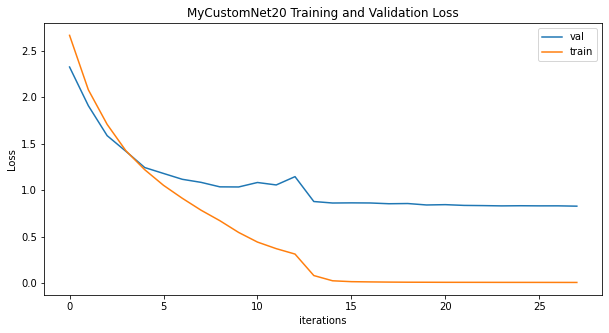

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet20 Training and Validation Loss")
plt.plot(val_loss_array,label="val")
plt.plot(train_loss_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

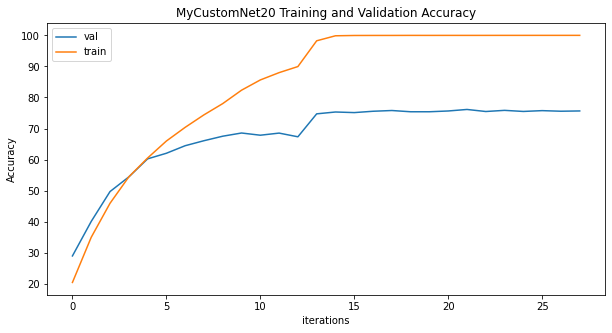

In [ ]:
plt.figure(figsize=(10,5))
plt.title("MyCustomNet20 Training and Validation Accuracy")
plt.plot(val_acc_array,label="val")
plt.plot(train_acc_array,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluating Accuracy on test set
num_correct = 0
num_samples = 0
for batch_idx, (data,targets, fine_targets) in enumerate(test_loader):
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    fine_targets = fine_targets.to(DEVICE)
    ## Forward Pass
    scores = model20(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == fine_targets).sum()
    num_samples += predictions.size(0)
print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 75.51%


In [ ]:
summary(model20,input_size=(3,80,80)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
            Conv2d-4          [-1, 128, 80, 80]          73,856
       BatchNorm2d-5          [-1, 128, 80, 80]             256
              ReLU-6          [-1, 128, 80, 80]               0
         MaxPool2d-7          [-1, 128, 40, 40]               0
            Conv2d-8          [-1, 128, 40, 40]         147,584
       BatchNorm2d-9          [-1, 128, 40, 40]             256
             ReLU-10          [-1, 128, 40, 40]               0
           Conv2d-11          [-1, 128, 40, 40]         147,584
      BatchNorm2d-12          [-1, 128, 40, 40]             256
             ReLU-13          [-1, 128, 40, 40]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [45]:
super_class = ["aquatic mammals",
"fish",
"flowers",
"food containers",
"fruit and vegetables",
"household electrical devices",
"household furniture",
"insects",
"large carnivores",
"large man-made outdoor things",
"large natural outdoor scenes",
"large omnivores and herbivores",
"medium-sized mammals",
"non-insect invertebrates",
"people",
"reptiles",
"small mammals",
"trees",
"vehicles 1",
"vehicles 2"
]

In [ ]:
#Save the model
torch.save(model20, 'MyCustomNetCIFAR100for20.pt')

In [44]:
#Load model
# Model class must be defined somewhere
model20 = torch.load('MyCustomNetCIFAR100for20.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


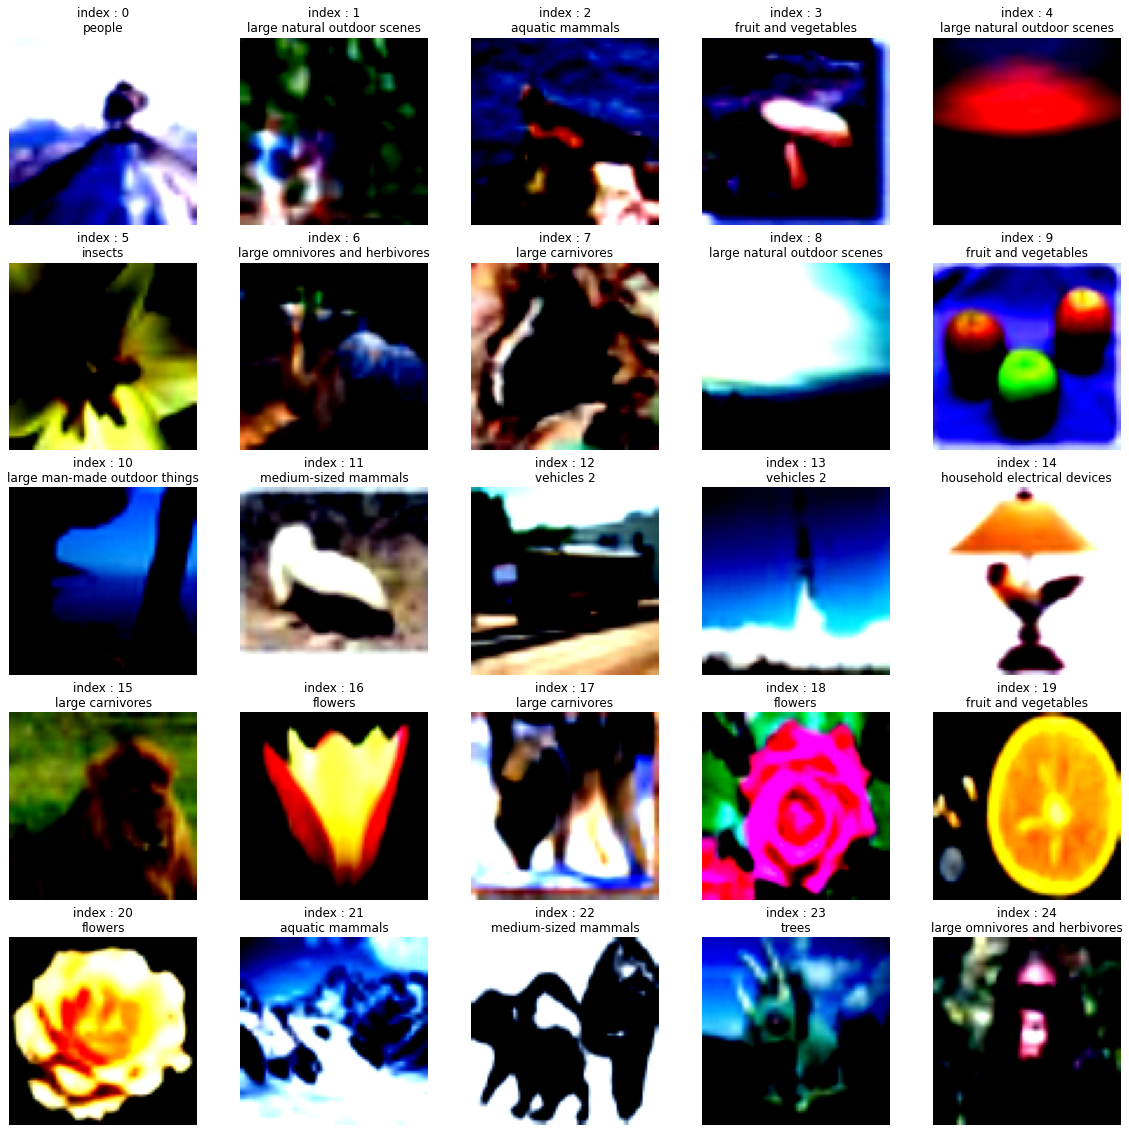

In [ ]:
#Evaluating model on testloader
test_images = iter(test_loader)
plt.figure(figsize=(20, 20)) # Set figure size 
data, target, fine_target= next(test_images) # get the images from the test images that we iterate over
image = data.to(DEVICE)
labels = fine_target.to(DEVICE)
#img, labels = images.to(device), labels.to(device) # pass images to GPU
model20.eval() # Set model to evaluation mode 
predictions = model20(image) # Predict the probabilities of each class for the image
y_pred = torch.argmax(predictions, dim=1).to(DEVICE) # Get the class index of the highest probability

for i in range(25): # Loop thru 16 images 
  ax = plt.subplot(5, 5, i + 1) # Make subplot to show multiple images
  plt.imshow(data[i].permute(1,2,0))#.numpy().reshape((80,80)).astype("uint8")
  current_index = i
  plt.title(f"index : {current_index}\n{super_class[int(y_pred[current_index:current_index+1])]}")
  plt.axis("off")